# Introduction


**ASSIGNMENT DEADLINE: 4 MAR 2018 (SUN) 17:00PM**

In this assignment we will be coding the building blocks for the convolutional neural network and putting them together to train a CNN on the MNIST dataset.

**Attention: Only python3 will be allowed to use in this assignment. And we use `numpy` to store and caculate data and parameters. You do not need a GPU to for this assignment. CPU is enough. To run this Jupyter notebook, you need to install the depedent libraries in [requiremets.txt](requirements.txt) via pip (or pip3). Note: keras version should be >=2.1.2. Please do not run this whole file before you implement all the codes. Otherwise it will occur some error.**

For each layer we will implement a forward and a backward function. The forward function will receive inputs and will return the outputs of this layer(loss layer will be a little different), like this:

```python
def forward(self, inputs):
  """ Receive inputs and return output"""
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  outputs = # the outputs
    
  return outputs
```

The backward pass will receive upstream derivatives and inputs, and will return gradients with respect to the inputs. Gradients for weights or bias will be stored in parameters in this layer , like this:

```python
def backward(self, in_grads, inputs):
  """
  Receive derivative of loss with respect to outputs,
  and compute derivative with respect to inputs.
  """
  # Use values in cache to compute derivatives
  out_grads = # Derivative of loss with respect to inputs
  self.w_grad = # Derivative of loss with respect to self.weights
  self.b_grad = # Derivative of loss with respect to self.bias
    
  return out_grads
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

This iPython notebook serves to:

- explain the questions
- explain the function APIs and implementation examples (like `ReLU`) 
- provide helper functions to piece functions together and check your code

# ReLU layer
A convolution layer is usually followed by a non-linear activation function. We will provide the functions `forward` and `backward` of class `ReLU` in `layers.py` as an implementation example. Read through the function code and make sure you understand the derivation. Besides, we will explain the implementation of `ReLU` after `Convolution` using formula. You need to write down other layers' formulations in your reports.

## Forward Formulation
Given input $x \in R^{B \times C \times H \times W}$ ($B$:batch size, $C$: number of channel, $H$: input height, $W$: input width),  output $y \in R^{B \times C \times H \times W}$ will be caculated like this:

\begin{equation*}
y=indicator(x) \times x
\end{equation*}

Here, $indicator(x)$ return the same size of input $x$, comparing $x$ with 0 element-wisely. If $x_{i,j,k,l} \geq 0$ return $z_{i,j,k,l}=1$. And the multiplication is also element-wise. If the input $x$ has only 2 dimensions, i.e. the batch dimension and the feature dimension, e.g. after the FC layer, the subscripts $j,k,l$ in the formula are merged into one $j$.

## Backward Formulation
Given input $x \in R^{B \times C \times H \times W}$ ($B$:batch size, $C$: number of channel, $H$: input height, $W$: input width) and gradients to output of this layer $dy \in R^{B \times C \times H \times W}$, gradients to input $dx$ will be caculated like this:

\begin{equation*}
dx=indicator(x) \times dy
\end{equation*}

# Covolution Layer
In the file `layers.py`, the class `Convolution` will be initialized with `conv_params`, `initializer` and `name`, shown as below:

```python

def __init__(self, conv_params, initializer=Guassian(), name='conv'):
        super(Convolution, self).__init__(name=name)
        self.trainable = True
        self.kernel_h = conv_params['kernel_h'] # height of kernel
        self.kernel_w = conv_params['kernel_w'] # width of kernel
        self.pad = conv_params['pad']
        self.stride = conv_params['stride']
        self.in_channel = conv_params['in_channel']
        self.out_channel = conv_params['out_channel']

        self.weights = initializer.initialize((self.out_channel, self.in_channel, self.kernel_h, self.kernel_w))
        self.bias = np.zeros((self.out_channel))

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)
```

`conv_params` is a dictionary, containing these parameters:

- 'kernel_h': The height of kernel.
- 'kernel_w': The width of kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels padded to the bottom, top, left and right of each feature map. **Here, `pad=2` means a 2-pixel border of padded with zeros. So the total number of zeros for horizontal (or vertical) direction is 2\*pad=4**.
- 'in_channel': The number of input channels.
- 'out_channel': The number of output channels.

`initializer` is an instance of Initializer class (leave it out right now)

# Forward
In the file `layers.py`, implement the forward pass for a convolutional layer in the function `forward` of class `Convolution`.

The input consists of N data points, each with C channels, height H and width W. We convolve each input with K different kernels, where each filter spans all C channels and has height HH and width WW.

Input:

- inputs: Input data of shape (N, C, H, W)

**WARNING:** Please implement the matrix product method of convolution as shown in Lecture notes. The naive version of implementing a sliding window will be too slow when you try to train the whole CNN in later sections.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [ ]:
import numpy as np
from layers import Convolution
from utils.tools import rel_error

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

inputs = np.random.uniform(size=(10, 3, 30, 30))
params = { 'kernel_h': 5,
          'kernel_w': 5,
          'pad': 0,
          'stride': 2,
          'in_channel': inputs.shape[1],
          'out_channel': 64,
}
layer = Convolution(params)
out = layer.forward(inputs)

keras_model = keras.Sequential()
keras_layer = layers.Conv2D(filters=params['out_channel'],
                            kernel_size=(params['kernel_h'], params['kernel_w']),
                            strides=(params['stride'], params['stride']),
                            padding='valid',
                            data_format='channels_first',
                            input_shape=inputs.shape[1:])
keras_model.add(keras_layer)
sgd = optimizers.SGD(lr=0.01)
keras_model.compile(loss='mean_squared_error', optimizer='sgd')
weights = np.transpose(layer.weights, (2 , 3, 1, 0))
keras_layer.set_weights([weights, layer.bias])
keras_out = keras_model.predict(inputs, batch_size=inputs.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

## Backward
Implement the backward pass for the convolution operation in the function `backward` of `Convolution` class in the file `layers.py`. 

When you are done, restart jupyter notebook and run the following to check your backward pass with a numeric gradient check. 

In gradient checking, to get an approximate gradient for a parameter, we vary that parameter by a small amount (while keeping rest of parameters constant) and note the difference in the network loss. Dividing the difference in network loss by the amount we varied the parameter gives us an approximation for the gradient. We repeat this process for all the other parameters to obtain our numerical gradient. Note that gradient checking is a slow process (2 forward propagations per parameter) and should only be used to check your backpropagation!

More links on gradient checking:

http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/

https://www.coursera.org/learn/machine-learning/lecture/Y3s6r/gradient-checking

In [ ]:
from layers import Convolution
import numpy as np
from utils.check_grads import check_grads_layer

batch = 10
conv_params={
    'kernel_h': 3,
    'kernel_w': 3,
    'pad': 0,
    'stride': 2,
    'in_channel': 3,
    'out_channel': 10
}
in_height = 10
in_width = 20
out_height = 1+(in_height+2*conv_params['pad']-conv_params['kernel_h'])//conv_params['stride']
out_width = 1+(in_width+2*conv_params['pad']-conv_params['kernel_w'])//conv_params['stride']
inputs = np.random.uniform(size=(batch, conv_params['in_channel'], in_height, in_width))
in_grads = np.random.uniform(size=(batch, conv_params['out_channel'], out_height, out_width))
conv = Convolution(conv_params)
check_grads_layer(conv, inputs, in_grads)

# Dropout Layer
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In the file `layers.py`, the class `FCLayer` will be initialized with `ratio`, `seed` and `name`, shown as below:
```python
def __init__(self, ratio, name='dropout', seed=None):
        super(Dropout, self).__init__(name=name)
        self.ratio = ratio
        self.mask = None
        self.seed = seed
```

- `ratio`: The probability of setting a neuron to zero
- `seed`: Random seed to sample from inputs, so as to get mask. (default as None)

## Forward
In the file `layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.  `p` refers to the probability of setting a neuron to zero. We will follow the Caffe convention where we multiply the outputs by `1/(1-p)` during training. 

## Backward
In the file `layers.py`, implement the backward pass for dropout. After doing so, restart jupyter notebook and run the following cell to numerically gradient-check your implementation.

In [ ]:
from layers import Dropout
import numpy as np
from utils.check_grads import check_grads_layer
batch=10
ratio = 0.1
height = 10
width = 20
channel = 10
np.random.seed(1234)
inputs = np.random.uniform(size=(batch, channel, height, width))
in_grads = np.random.uniform(size=(batch, channel, height, width))
dropout = Dropout(ratio, seed=1234)
dropout.set_mode(True)
check_grads_layer(dropout, inputs, in_grads)

# Pooling Layer
In the file `layers.py`, the class `Pooling` will be initialized with `pool_params`, and `name`, shown as below:
```python
def __init__(self, pool_params, name='pooling'):
        super(Pooling, self).__init__(name=name)
        self.pool_type = pool_params['pool_type']
        self.pool_height = pool_params['pool_height']
        self.pool_width = pool_params['pool_width']
        self.stride = pool_params['stride']
        self.pad = pool_params['pad']
```

`pool_params` is a dictionary, containing these parameters:

- 'pool_type': The type of pooling, 'max' or 'avg'
- 'pool_h': The height of pooling kernel.
- 'pool_w': The width of pooling kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels that will be used to zero-pad the input in each x-y direction. **Here, `pad=2` means a 2-pixel border of padding with zeros**.

## Forward
Implement the forward pass for the pooling operation in the function `forward` of class `Pooling` in the file `layers.py`.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [ ]:
import numpy as np
from layers import Pooling
from utils.tools import rel_error

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

inputs = np.random.uniform(size=(10, 3, 30, 30))
params = { 'pool_type': 'max',
           'pool_height': 5,
           'pool_width': 5,
           'pad': 0,
           'stride': 2,
}
layer = Pooling(params)
out = layer.forward(inputs)

keras_model = keras.Sequential()
keras_layer = layers.MaxPooling2D(pool_size=(params['pool_height'], params['pool_width']),
                                 strides=params['stride'],
                                 padding='valid',
                                 data_format='channels_first',
                                 input_shape=inputs.shape[1:])
keras_model.add(keras_layer)
sgd = optimizers.SGD(lr=0.01)
keras_model.compile(loss='mean_squared_error', optimizer='sgd')
keras_out = keras_model.predict(inputs, batch_size=inputs.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

In [ ]:
## Backward
#Implement the backward pass for the max-pooling operation in the function `backward` of class `Pooling` in the file `layers.py`.
#Please make sure you have implemented both ’max’ and ’avg’ pooing in your codes. And then test the gradients by yourself.

from layers import Pooling
import numpy as np
from utils.check_grads import check_grads_layer

import warnings
warnings.filterwarnings('ignore')

params = { 'pool_type': 'max',
           'pool_height': 5,
           'pool_width': 5,
           'pad': 0,
           'stride': 2,
}
in_height = 10
in_width = 20
out_height = 1+(in_height+2*params['pad']-params['pool_height'])//params['stride']
out_width = 1+(in_width+2*params['pad']-params['pool_width'])//params['stride']
inputs = np.random.uniform(size=(10, 3, in_height, in_width))
in_grads = np.random.uniform(size=(10, 3, out_height, out_width))
pool = Pooling(params)
check_grads_layer(pool, inputs, in_grads)

# FC Layer

FC layer (short for fully connected layer) is also called linear layer or dense layer.

In the file `layers.py`, the class `FCLayer` will be initialized with `in_features`, `out_features`, and `name`, shown as below:
```python
def __init__(self, in_features, out_features, name='fclayer', initializer=Guassian()):
        super(FCLayer, self).__init__(name=name)
        self.trainable = True
        self.weights = initializer.initialize((in_features, out_features))
        self.bias = initializer.initialize(out_features)

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)
```

- `in_features`: The number of inputs features
- `out_features`: The numbet of required outputs features

## Forward
Implement the forward pass for the pooling operation in the function `forward` of class `FCLayer` in the file `layers.py`.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [ ]:
import numpy as np
from layers import FCLayer
from utils.tools import rel_error

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

inputs = np.random.uniform(size=(10, 20))

layer = FCLayer(in_features=inputs.shape[1], out_features=100)
out = layer.forward(inputs)

keras_model = keras.Sequential()
keras_layer = layers.Dense(100, input_shape=inputs.shape[1:], use_bias=True, kernel_initializer='random_normal', bias_initializer='zeros')
# print (len(keras_layer.get_weights()))
keras_model.add(keras_layer)
sgd = optimizers.SGD(lr=0.01)
keras_model.compile(loss='mean_squared_error', optimizer='sgd')
keras_layer.set_weights([layer.weights, layer.bias])
keras_out = keras_model.predict(inputs, batch_size=inputs.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

In [ ]:
## Backward
#Implement the backward pass for the max-pooling operation in the function `backward` of class `FCLayer` in the file `layers.py`. Please test the gradients by yourself.

from layers import FCLayer
import numpy as np
from utils.check_grads import check_grads_layer

import warnings
warnings.filterwarnings('ignore')

inputs = np.random.uniform(size=(10, 20));
in_grads = np.random.uniform(size=(10, 100))
fclayer = FCLayer(in_features=20, out_features=100)
check_grads_layer(fclayer, inputs, in_grads)

# SoftmaxCrossEntropy Loss
We write Softmax and CrossEntropy together because it can avoid some numeric overflow problem.In the file `loss.py`, the class `SoftmaxCrossEntropy` will be initialized with `num_class`,  shown as below:
```python
def __init__(self, num_class):
        super(SoftmaxCrossEntropy, self).__init__()
        self.num_class = num_class
```

`num_class`: The number of category

## Forward
Implement the forward pass for the pooling operation in the function `forward` of class `FCLayer` in the file `layers.py`.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [ ]:
import numpy as np
from loss import SoftmaxCrossEntropy
from utils.tools import rel_error

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

batch = 10
num_class = 10
inputs = np.random.uniform(size=(batch, num_class))
targets = np.random.randint(num_class, size=batch)

loss = SoftmaxCrossEntropy(num_class)
out, _ = loss.forward(inputs, targets)

keras_inputs = K.softmax(inputs)
keras_targets = np.zeros(inputs.shape, dtype='int')
for i in range(batch):
        keras_targets[i, targets[i]] = 1
keras_out = K.mean(K.categorical_crossentropy(keras_targets, keras_inputs, from_logits=False))
print(out)
print(K.eval(keras_out))
print('Relative error (<1e-6 will be fine): ', rel_error(out, K.eval(keras_out)))

In [ ]:
## Backward
# In the file `loss.py`, implement the backward pass for `SoftmaxCrossEntropy`. Please test the gradients by yourself.

import numpy as np
from loss import SoftmaxCrossEntropy
from utils.check_grads import check_grads_loss

import warnings
warnings.filterwarnings('ignore')

batch = 10
num_class = 10
inputs = np.random.uniform(size=(batch, num_class))
targets = np.random.randint(num_class, size=batch)
loss = SoftmaxCrossEntropy(num_class)
check_grads_loss(loss, inputs, targets)

# Optimizer
In the file `optimizers.py`, there are 4 types of optimizer (`SGD`, `Adam`, `RMSprop` and `Adagrad`). You only need to implement the `update` function of `SGD`(mini-batch SGD with momentum) and `Adam`. These two types of optimizers are initialized like this:

```python
class SGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0, decay=0, sheduler_func = None):
        super(SGD, self).__init__(lr)
        self.momentum = momentum
        self.moments = None
        self.decay = decay
        self.sheduler_func = sheduler_func
        
class Adam(Optimizer):
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, sheduler_func=None):
        super(Adam, self).__init__(lr)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.decay = decay
        if not self.epsilon:
            self.epsilon = 1e-8
        self.moments = None
        self.accumulators = None
        self.sheduler_func = sheduler_func
```

For Both optimizers:
- `lr`: The initial learning rate.
- `decay`: The learning rate decay ratio
- `sheduler_func`: Function to change learning rate with respect to iterations

For `SGD`:
- `momentum`: The ratio of moments


For `Adam`:
More details can be seen in reference.

**For you reference:**
http://cs231n.github.io/neural-networks-3/#update

# Train the net on full MNIST data
By training the `MNISTNet` for one epoch, you should achieve about 90% on the validation and test set. You may have to wait about 5 minutes for training to be completed.

Number of training images:  48000
Number of validation images:  12000
Number of testing images:  10000

Four examples of training images:


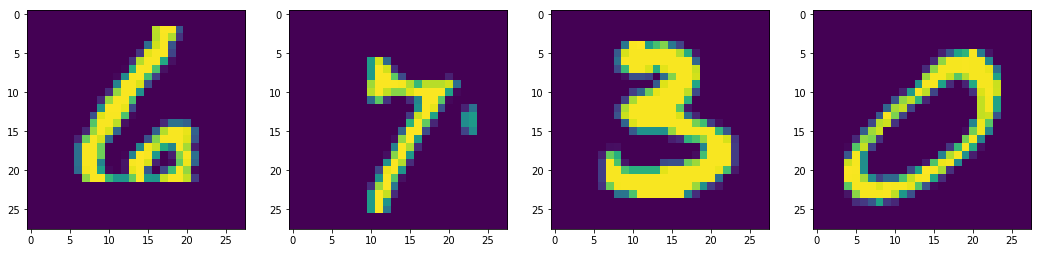

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from applications import MNISTNet
from loss import SoftmaxCrossEntropy, L2
from optimizers import Adagrad, Adam, RMSprop
from utils.datsets import MNIST
import numpy as np

mnist = MNIST()
mnist.load()
idx = np.random.randint(mnist.num_train, size=4)
print('\nFour examples of training images:')
img = mnist.x_train[idx][:,0,:,:]

plt.figure(1, figsize=(18, 18))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.subplot(1, 4, 2)
plt.imshow(img[1])
plt.subplot(1, 4, 3)
plt.imshow(img[2])
plt.subplot(1, 4, 4)
plt.imshow(img[3])

In [ ]:
model = MNISTNet()
loss = SoftmaxCrossEntropy(num_class=10)

# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

adam = RMSprop(lr=0.001, decay=0,  sheduler_func = func)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, loss=loss, regularization=l2)
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=30, val_batch=1000, test_batch=1000, 
    epochs=2, 
    val_intervals=100, test_intervals=300, print_intervals=100)

Epoch 0: 
Test accuracy=0.10080, loss=2.30259
Validation accuracy: 0.09508, loss: 2.30259
Iteration 0:	accuracy=0.20000, loss=2.30259, regularization loss= 0.005287661552302978
Validation accuracy: 0.10600, loss: 2.30234
Iteration 100:	accuracy=0.20000, loss=2.30018, regularization loss= 0.0019655938426539456
Validation accuracy: 0.10600, loss: 2.30212
Iteration 200:	accuracy=0.16667, loss=2.29855, regularization loss= 0.0007510983981031626
Test accuracy=0.11350, loss=2.30178
Validation accuracy: 0.10600, loss: 2.30213
Iteration 300:	accuracy=0.10000, loss=2.30357, regularization loss= 0.0002991660250718179
Validation accuracy: 0.10600, loss: 2.30197
Iteration 400:	accuracy=0.13333, loss=2.29274, regularization loss= 0.00015351510418540367
Validation accuracy: 0.10600, loss: 2.29958
Iteration 500:	accuracy=0.03333, loss=2.29979, regularization loss= 0.0002636141375401724
Test accuracy=0.34440, loss=1.88961
Validation accuracy: 0.33350, loss: 1.91060
Iteration 600:	accuracy=0.30000, los

In [ ]:
plt.figure(2, figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 3, 4)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 3, 2)
plt.title('Validation loss')
plt.plot(val_results[:,0], val_results[:,1])
plt.subplot(2, 3, 5)
plt.title('Validation accuracy')
plt.plot(val_results[:,0], val_results[:,2])
plt.subplot(2, 3, 3)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 3, 6)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

## Change of learning rate
If we change the initial learning rate from 0.001 to 0.1, the training process becomes unstable and the loss is out of control. Thus, you need to be careful when setting the initial learning rate.

In [ ]:
model = MNISTNet()
loss = SoftmaxCrossEntropy(num_class=10)

# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

adam = Adam(lr=0.01, decay=0,  sheduler_func = func)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, loss=loss, regularization=l2)
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=30, val_batch=1000, test_batch=1000, 
    epochs=2, 
    val_intervals=100, test_intervals=300, print_intervals=100)

In [ ]:
plt.figure(2, figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 3, 4)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 3, 2)
plt.title('Validation loss')
plt.plot(val_results[:,0], val_results[:,1])
plt.subplot(2, 3, 5)
plt.title('Validation accuracy')
plt.plot(val_results[:,0], val_results[:,2])
plt.subplot(2, 3, 3)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 3, 6)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

# Train your best MNISTNet!
Tweak the hyperparameters of the above MNISTNet and use what you've learnt to train the best net.

Credits will be given based on your test accuracy, your explanations/insights of the training. The network is small, hence the training should finish quickly using your CPU (less than 1 hour). 

Please report the following:
- Training validation and testing loss as well as accuracy over iterations
- Architecture and training method (eg. optimization scheme, data augmentation): explain your design choices, what has failed and what has worked and why you think they worked/failed
- Try different hyper-parameters, e.g. rate decaying, weight decay, number of layers and total number of epochs. 

Do NOT use external libraries like Tensorflow, keras and Pytorch in your implementation, i.e. optimizer.py, layer.py and loss.py. Do NOT copy the code from the internet, e.g. github. You should also give credits to any material that you refer to for your implementation.

# Final submission instructions
Please submit the following:

1) Your code files in a folder `codes`

2) A short report (1-2 pages) in pdf titled `report.pdf`, explaining the logic (expressed using mathematical formulation) of your implementation (including the forward and backward function like ReLU) and the findings from training your best net

**ASSIGNMENT DEADLINE: 4 MAR 2018 (SUN) 17:00PM**

Do not include the `data` folder as it takes up substantial memory. Please zip up the following folders under a folder named with your NUSNET ID: eg. `e0123456g.zip' and submit the zipped folder to IVLE/workbin/assignment 1 submission.